# 00. Primer Acercamiento a Clasificación con Distancia de Fermat: LandmarksClassifier
La clase `fermat.Fermat` sólo devuelve distancias entre las observaciones de entrenamiento `X_train` pasadas a `Fermat.fit(X_train)`. Para usar la estimación $D_{\mathbb{X}_n}$ de la distancia de Fermat $\mathcal{D_f}$ en tareas de clasificación, hay que extenderla a puntos no observados.

En este _notebook_ propongo la versión más bruta posible: para cada clase de entrenamiento (`X_train[y_train == cls]`), agregar la observación a predecir a la clase, calcular las nuevas distancias $D_{\mathbb{X}_{n+1}}$, y tomar el promedio de las distancias de la observación a los elementos de la clase de entrenamiento. Asignar la observación a la clase con menor distancia promedio.

Una sofisticación inmediata: es posible calcular las distancias de una nueva observación `x` a una muestra de tamaño `n`, en orden `n` 

In [49]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from fermat import Fermat
from sklearn.datasets import load_iris

In [50]:
X, y = load_iris(return_X_y=True, as_frame=True)
N, D = X.shape
N, D

(150, 4)

In [51]:
classes = y.unique()
all_distances = distance_matrix(X, X)
cls_distances = {cls: distance_matrix(X[y == cls], X[y == cls]) for cls in classes}


In [14]:
all_distances.shape, {i: X.shape for i, X in cls_distances.items()}

((150, 150), {0: (50, 50), 1: (50, 50), 2: (50, 50)})

**CUIDADO**: Si tomo `f = Fermat(alpha=4, path_method="FW", ...)`
Sucesivas llamadas a `f.fit(X)` retornan una nueva instancia Fermat fiteada, pero fitean también el `f` "de base". Es un comportamiento esperado para los BaseEstimator de sklearn. Es problemático, el `partial` te deja trabajar con un "factory" manejable.

In [15]:
from functools import partial
f = partial(Fermat, alpha=4, path_method="FW")
f_all = f().fit(all_distances)
f_cls = {cls: f().fit(cls_distances[cls]) for cls in classes}

For any two points decide if they belong to the same class or not according to the distance in every class:

In [16]:
def get_distance_through(p, q, cls):
    nodes = pd.concat([X.loc[[p, q]], X[y == cls]])
    dist_mat = distance_matrix(X, X)
    return f().fit(dist_mat).get_distance(0, 1)

In [17]:
for p, q in np.random.randint(0, N, (3, 2)):
    print(f"p := {X.loc[p].values} (class {y[p]})")
    print(f"q := {X.loc[q].values} (class {y[q]})")
    dists = {}
    dists["all"] = f_all.get_distance(p, q)
    for cls in classes:
        dists[cls] = get_distance_through(p, q, cls)
    print(pd.Series(dists))

p := [5.4 3.4 1.5 0.4] (class 0)
q := [6.2 2.8 4.8 1.8] (class 2)
all    7.5175
0      0.0049
1      0.0049
2      0.0049
dtype: float64
p := [7.4 2.8 6.1 1.9] (class 2)
q := [5.5 2.4 3.8 1.1] (class 1)
all    0.2128
0      0.0049
1      0.0049
2      0.0049
dtype: float64
p := [6.2 2.2 4.5 1.5] (class 1)
q := [6.2 2.9 4.3 1.3] (class 1)
all    0.1297
0      0.0049
1      0.0049
2      0.0049
dtype: float64


No tiene mucha utilidad el paquete de Fermat para clasificar as-is o estoy loco? No generaliza bien la distancia a nuevos puntos.

## Out-out-training predictions for FermatKMeans

In [18]:
import itertools as it
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import euclidean_distances
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
from fermat.kmedoids import KMedoids

In [19]:
class LandmarksClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self, alpha=2, k=5, method="kmedoids", seed=None
    ):  # number of landmarks to take from each class
        self.alpha = alpha
        self.k = k
        self.seed = seed or np.random.randint(2**32 - 1)
        self.rs = RandomState(self.seed)
        if method not in ["kmedoids", "random"]:
            raise ValueError(f"{self.method} is not a valid landmarks' choosing method")
        self.method = method

    def fit(self, X, y):
        self.landmarks_ = {}
        for cls in np.unique(y):
            X_cls = X[y == cls]
            n_cls = X_cls.shape[0]
            if self.method == "kmedoids":
                fmt = Fermat(alpha=self.alpha, path_method="FW", seed=self.seed)
                fmt.fit(euclidean_distances(X_cls))
                km = KMedoids(iterations=10, seed=self.seed)
                distance_matrix = fmt.get_distances()
                labels = km(distance_matrix, min(self.k, n_cls))
                self.landmarks_[cls] = X_cls[km._find_centers(distance_matrix, labels)]
            else:
                self.landmarks_[cls] = X_cls[self.rs.randint(0, n_cls)]

    def _distances(self, x):
        distances = {}
        for cls, landmarks in self.landmarks_.items():
            X_cls = np.vstack([x, landmarks])
            fmt = Fermat(alpha=self.alpha, path_method="FW", seed=self.seed)
            fmt.fit(euclidean_distances(X_cls))
            distance_matrix = fmt.get_distances()
            distances[cls] = distance_matrix[0].mean()  # x is at th the top of X_cls
        return distances

    def _predict(self, x):
        distances = self._distances(x)
        return min(distances, key=distances.get)

    def predict(self, X):
        return np.apply_along_axis(lclf._predict, 1, X)


In [20]:
config = dict(
    n_iter=16,
    test_sizes=[0.1, 0.5],
    datasets=["digits", "iris", "breast_cancer", "wine", "diabetes"],
    alphas=[0.5, 1, 1.5, 2, 3, 4],
    ks=[3, 10, 30, 100],
    methods=["kmedoids", "random"],
    # n_estimators=[3, 10, 30]   # TODO: LATER
    # max_depths=[3, 6, 9]
)
simple_config = dict(
    n_iter=1,
    test_sizes=[0.1],
    datasets=["digits"],
    alphas=[2],
    ks=[10],
    methods=["kmedoids"],
    # n_estimators=[3, 10, 30]   # TODO: LATER
    # max_depths=[3, 6, 9]
)

In [21]:
def run(n_iter, test_sizes, datasets, alphas, ks, methods):
    from sklearn import datasets as sk_datasets
    runs = []
    for ds, size in it.product(datasets, test_sizes):
        log = {"ds": ds, "size": size}
        print(log)
        loader = eval(f"sk_datasets.load_{ds}")
        X, y = loader(return_X_y=True)
        for i in range(n_iter):
            log["i"] = i
            print(log)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=size, random_state=i
            )
            try:
                rfclf = RandomForestClassifier(n_estimators=10)
                rfclf.fit(X_train, y_train)
                runs.append({"method": "rf", "score": rfclf.score(X_test, y_test), **log})
            except:
                print(f"Problem with RF for {log}")
            for alpha, k, method in it.product(alphas, ks, methods):
                # New keys must be at the end to replace previous values in the loop
                log = {**log, "alpha": alpha, "k": k, "method": method}
                print(log)
                try:
                    lclf = LandmarksClassifier(alpha=alpha, k=k, method=method)
                    lclf.fit(X_train, y_train)
                    runs.append({"score": lclf.score(X_test, y_test), **log})
                except Exception as e:
                    print(f"Problem with Landmarks for {log}")

    return runs


In [22]:
runs = run(**simple_config)

{'ds': 'digits', 'size': 0.1}
{'ds': 'digits', 'size': 0.1, 'i': 0}
{'ds': 'digits', 'size': 0.1, 'i': 0, 'alpha': 2, 'k': 10, 'method': 'kmedoids'}
Problem with Landmarks for {'ds': 'digits', 'size': 0.1, 'i': 0, 'alpha': 2, 'k': 10, 'method': 'kmedoids'}


In [29]:
# from sklearn.model_selection import train_test_split
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rfclf = RandomForestClassifier(n_estimators=10)
rfclf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10)

In [30]:
rfclf.score(X_test, y_test)

0.9361111111111111

In [31]:
classes = {}
alpha = 2
seed = 34
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=seed
)
for cls in np.unique(y_train):
    X = X_train[y_train == cls]
    n = X.shape[0]
    fmt = Fermat(alpha=alpha, path_method="FW", seed=seed)
    fmt.fit(euclidean_distances(X))
    classes[cls] = dict(verts=X, dists=fmt.get_distances())

In [32]:
classes[0]["dists"].shape

(142, 142)

In [33]:
ix = np.random.randint(0, X_test.shape[0])
x, y = X_test[ix], y_test[ix]
# plt.imshow(1- x.reshape(8,8), cmap="gray")
# plt.suptitle(y), plt.show()

In [34]:
ix, y, x

(352,
 5,
 array([ 0.,  0., 14., 12., 12., 13.,  0.,  0.,  0.,  1., 16.,  8.,  8.,
         6.,  0.,  0.,  0.,  4., 15.,  8.,  4.,  0.,  0.,  0.,  0.,  2.,
        12., 12., 15., 13.,  1.,  0.,  0.,  0.,  0.,  0.,  1., 13.,  8.,
         0.,  0.,  0.,  0.,  0.,  0., 11.,  7.,  0.,  0.,  5., 14.,  4.,
         7., 15.,  2.,  0.,  0.,  1., 10., 16., 15.,  5.,  0.,  0.]))

In [35]:
cls = 2
klass = classes[cls]
verts, dists = klass["verts"], klass["dists"]
n = verts.shape[0]
to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
all_dists = fmt.fit(euclidean_distances(np.vstack([x, verts]))).get_distances()


In [36]:
new_dists = [min(to_verts + dists[:, i]) for i in range(n)]
assert np.allclose([0] + new_dists, all_dists[0])

### ÉXITO PAPÁÁÁÁÁÁÁ

In [37]:
from scipy.stats import norm
kern = norm.pdf

In [38]:
mu, sigma = np.mean(all_dists), np.std(all_dists)
hs = np.linspace(mu - 2 * sigma, mu + 2 * sigma, 5)  # bandwiths

In [39]:
hs

array([ 103.19606423,  696.11453659, 1289.03300895, 1881.95148131,
       2474.86995367])

In [40]:
h = mu


In [41]:
y_test.shape

(360,)

In [42]:
preds = []
fhats = []
for x in X_test:
    fhat = {}
    for cls in classes.keys():
        klass = classes[cls]
        verts, dists = klass["verts"], klass["dists"]
        n = verts.shape[0]
        to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
        fmt_dists = [min(to_verts + dists[:, i]) for i in range(n)]
        # print(cls, np.mean(fmt_dists))
        fhat[cls] = (1 / h**D) * np.mean([kern(d / h) for d in fmt_dists])
    fhats.append(fhat)
    preds.append(pd.Series(fhat).argmax())

In [43]:
densities = pd.DataFrame(fhats)
densities["true"] = y_test
densities["pred"] = preds
densities#[densities.true != densities.pred]

,0,1,2,3,4,5,6,7,8,9,true,pred
0,1.068820e-14,2.552361e-14,1.898977e-14,3.046839e-14,2.309662e-14,2.660043e-14,6.086556e-15,1.017489e-13,3.637977e-14,2.558533e-14,7,7
1,4.021965e-14,6.757915e-14,5.320389e-14,2.863684e-14,2.991795e-14,4.274162e-14,3.059624e-14,4.184533e-14,8.697217e-14,3.047211e-14,8,8
2,3.813718e-14,3.318405e-14,3.116784e-14,3.677895e-14,4.660963e-14,1.991906e-14,1.742706e-14,9.426391e-14,4.439967e-14,2.263444e-14,7,7
3,7.215391e-14,2.322444e-14,2.676600e-14,2.235910e-14,4.885000e-14,3.365137e-14,1.262691e-13,1.078706e-14,3.877736e-14,2.295853e-14,6,6
4,4.944950e-14,1.962587e-14,2.419968e-14,1.201460e-14,4.176388e-14,2.502880e-14,1.136630e-13,7.098832e-15,2.949903e-14,1.126276e-14,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
355,2.612211e-14,5.366288e-14,3.984478e-14,6.010273e-14,1.532956e-14,5.571052e-14,2.120663e-14,3.166282e-14,7.923781e-14,3.146340e-14,8,8
356,1.141610e-13,1.470657e-14,2.559989e-14,4.212819e-14,3.884512e-14,7.039918e-14,3.869128e-14,3.545888e-14,4.740362e-14,5.612745e-14,0,0
357,1.120479e-14,1.172938e-14,8.969801e-15,2.122115e-14,2.503433e-14,1.787364e-14,5.830911e-15,7.488193e-14,2.048880e-14,1.423964e-14,7,7
358,3.518845e-14,2.947484e-14,9.640533e-14,5.790573e-14,7.415912e-15,2.864009e-14,2.770271e-14,3.468567e-14,6.161639e-14,3.831843e-14,2,2


In [44]:
densities = pd.DataFrame(fhats)
densities["true"] = y_test
densities["pred"] = preds
densities[densities.true != densities.pred]

,0,1,2,3,4,5,6,7,8,9,true,pred
8,3.526227e-14,9.552092e-15,2.835089e-14,4.845460e-14,3.656004e-15,4.708604e-14,3.216254e-14,3.202105e-15,1.860520e-14,6.364236e-14,5,9
13,7.631396e-14,2.017215e-14,2.717643e-14,5.759405e-14,3.151925e-14,5.277517e-14,6.320627e-14,4.347438e-14,7.554685e-14,7.084346e-14,8,0
39,1.593088e-14,3.376862e-14,5.254930e-14,4.549208e-14,1.545981e-14,3.269860e-14,2.684181e-14,2.912938e-14,4.383149e-14,3.710859e-14,8,2
52,2.960667e-14,3.127915e-14,5.772142e-14,5.992530e-14,1.402901e-14,1.397795e-14,1.892513e-14,3.059330e-14,2.909997e-14,3.712868e-14,2,3
60,1.768581e-14,8.244672e-14,6.265162e-14,5.604845e-14,3.535612e-14,2.541622e-14,3.147059e-14,5.246920e-14,7.964257e-14,2.862785e-14,8,1
62,1.174632e-14,4.085356e-14,4.230831e-15,1.285688e-14,3.714843e-14,2.752120e-14,6.842130e-15,4.390056e-14,3.395226e-14,3.581552e-14,9,7
63,3.523686e-14,4.160531e-14,2.021155e-14,1.269585e-14,1.484795e-14,4.431435e-14,1.762288e-14,3.593519e-14,4.413865e-14,2.044695e-14,8,5
95,3.887899e-14,2.072828e-14,1.934596e-14,3.508154e-14,3.053626e-14,5.085033e-14,6.377090e-15,6.717060e-14,4.623933e-14,5.999617e-14,9,7
146,7.188173e-14,1.084857e-14,4.229861e-14,4.298759e-14,1.209560e-14,1.135020e-14,2.184198e-14,1.853765e-14,2.546929e-14,3.401921e-14,2,0
187,1.345770e-14,4.025419e-14,2.149496e-14,2.488793e-14,3.139223e-14,5.919912e-14,1.299891e-14,5.950815e-14,5.337987e-14,3.754363e-14,9,7


In [45]:
densities

,0,1,2,3,4,5,6,7,8,9,true,pred
0,1.068820e-14,2.552361e-14,1.898977e-14,3.046839e-14,2.309662e-14,2.660043e-14,6.086556e-15,1.017489e-13,3.637977e-14,2.558533e-14,7,7
1,4.021965e-14,6.757915e-14,5.320389e-14,2.863684e-14,2.991795e-14,4.274162e-14,3.059624e-14,4.184533e-14,8.697217e-14,3.047211e-14,8,8
2,3.813718e-14,3.318405e-14,3.116784e-14,3.677895e-14,4.660963e-14,1.991906e-14,1.742706e-14,9.426391e-14,4.439967e-14,2.263444e-14,7,7
3,7.215391e-14,2.322444e-14,2.676600e-14,2.235910e-14,4.885000e-14,3.365137e-14,1.262691e-13,1.078706e-14,3.877736e-14,2.295853e-14,6,6
4,4.944950e-14,1.962587e-14,2.419968e-14,1.201460e-14,4.176388e-14,2.502880e-14,1.136630e-13,7.098832e-15,2.949903e-14,1.126276e-14,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
355,2.612211e-14,5.366288e-14,3.984478e-14,6.010273e-14,1.532956e-14,5.571052e-14,2.120663e-14,3.166282e-14,7.923781e-14,3.146340e-14,8,8
356,1.141610e-13,1.470657e-14,2.559989e-14,4.212819e-14,3.884512e-14,7.039918e-14,3.869128e-14,3.545888e-14,4.740362e-14,5.612745e-14,0,0
357,1.120479e-14,1.172938e-14,8.969801e-15,2.122115e-14,2.503433e-14,1.787364e-14,5.830911e-15,7.488193e-14,2.048880e-14,1.423964e-14,7,7
358,3.518845e-14,2.947484e-14,9.640533e-14,5.790573e-14,7.415912e-15,2.864009e-14,2.770271e-14,3.468567e-14,6.161639e-14,3.831843e-14,2,2


In [61]:
confusion = pd.DataFrame({"y_test": y_test, "preds": preds}).groupby(["y_test", "preds"]).apply(
    len
).rename("n").reset_index().pivot("y_test", "preds").fillna(0).astype(int)


In [67]:
confusion

n                                    
preds    0   1   2   3   4   5   6   7   8   9
y_test                                        
0       36   0   0   0   0   0   0   0   0   0
1        0  33   2   0   0   0   0   0   0   2
2        1   1  31   1   0   0   0   1   0   0
3        0   0   0  37   0   0   0   0   0   0
4        0   0   0   0  36   0   0   0   0   0
5        1   0   0   0   0  33   0   0   0   2
6        0   0   0   0   0   0  36   0   0   0
7        0   0   0   0   0   0   0  36   0   0
8        1   1   1   1   0   1   0   0  30   0
9        1   0   0   0   0   1   0   3   0  31

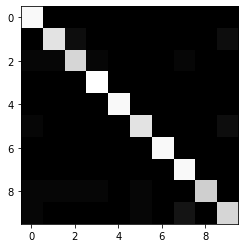

In [66]:
plt.imshow(confusion, cmap="gray")

In [47]:
pd.Series(preds).value_counts()

7    40
0    40
3    39
6    36
4    36
9    35
1    35
5    35
2    34
8    30
dtype: int64

In [52]:
(y_test == preds).mean()

0.9416666666666667

In [54]:
y_test[:10], preds[:10]

(array([7, 8, 7, 6, 6, 6, 2, 2, 5, 1]), [7, 8, 7, 6, 6, 6, 2, 2, 9, 1])

In [55]:
fhat

{0: 1.9781868690467263e-14,
 1: 2.696686960240373e-14,
 2: 8.869480667576087e-14,
 3: 6.455166722859588e-14,
 4: 4.372897887631067e-15,
 5: 2.5877738812493265e-14,
 6: 1.0854234484672095e-14,
 7: 4.3577071201559274e-14,
 8: 4.84251758888935e-14,
 9: 2.663531092088644e-14}

In [56]:
pd.Series(y_test).value_counts(), pd.Series(preds).value_counts()

(1    37
 3    37
 7    36
 6    36
 5    36
 0    36
 9    36
 4    36
 8    35
 2    35
 dtype: int64,
 7    40
 0    40
 3    39
 6    36
 4    36
 9    35
 1    35
 5    35
 2    34
 8    30
 dtype: int64)

In [ ]:
{i: np.mean(cls["dists"]) for i, cls in classes.items()}

{0: 0.0010472140039448103, 1: 0.001931632653061226, 2: 0.002776391186200444}

In [ ]:
pd.DataFrame(runs).to_csv("runs.csv", index=False)

In [ ]:
df = pd.read_csv("runs.csv")

In [ ]:
df[df.alpha.isna() | (df.k == 100)]

,method,score,ds,size,i,alpha,k
0,rf,0.950000,digits,0.1,0,NaN,NaN
7,kmedoids,0.916667,digits,0.1,0,0.5,100.0
8,random,0.722222,digits,0.1,0,0.5,100.0
15,kmedoids,0.888889,digits,0.1,0,1.0,100.0
16,random,0.661111,digits,0.1,0,1.0,100.0
...,...,...,...,...,...,...,...
7823,random,0.009050,diabetes,0.5,15,2.0,100.0
7830,kmedoids,0.004525,diabetes,0.5,15,3.0,100.0
7831,random,0.004525,diabetes,0.5,15,3.0,100.0
7838,kmedoids,0.004525,diabetes,0.5,15,4.0,100.0
